<a href="https://colab.research.google.com/github/devthumos/spaceship_titanic/blob/master/Spaceship_EDA_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis for Feature Engineering

This notebook serves for give a direction or hints of how to do feature engineering on the spaceship dataset and create new features, giving to the model more information and decreasing it's uncertainty related to the target

# Importing Libraries and Loading the Datset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [ ]:
train_raw = "https://raw.githubusercontent.com/devthumos/spaceship_titanic/master/train.csv"
test_raw = "https://raw.githubusercontent.com/devthumos/spaceship_titanic/master/test.csv"

train_set = pd.read_csv(train_raw)
test_set = pd.read_csv(test_raw)

In [ ]:
train_set.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_set.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

# Exploratory Data Analysis

### Numerical Features

In [ ]:
numerical_features = [feature for feature in train_set.columns if train_set[feature].dtype in ["int64", "float64"]]
numerical_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [ ]:
discrete_features = [feature for feature in train_set.columns if train_set[feature].dtype == "int64"]
discrete_features

[]

We can see that all numerical features are continuous

In [ ]:
continuous_features = [feature for feature in train_set.columns if train_set[feature].dtype == "float64"]
continuous_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Let's plot to see those features behavior in our training set?

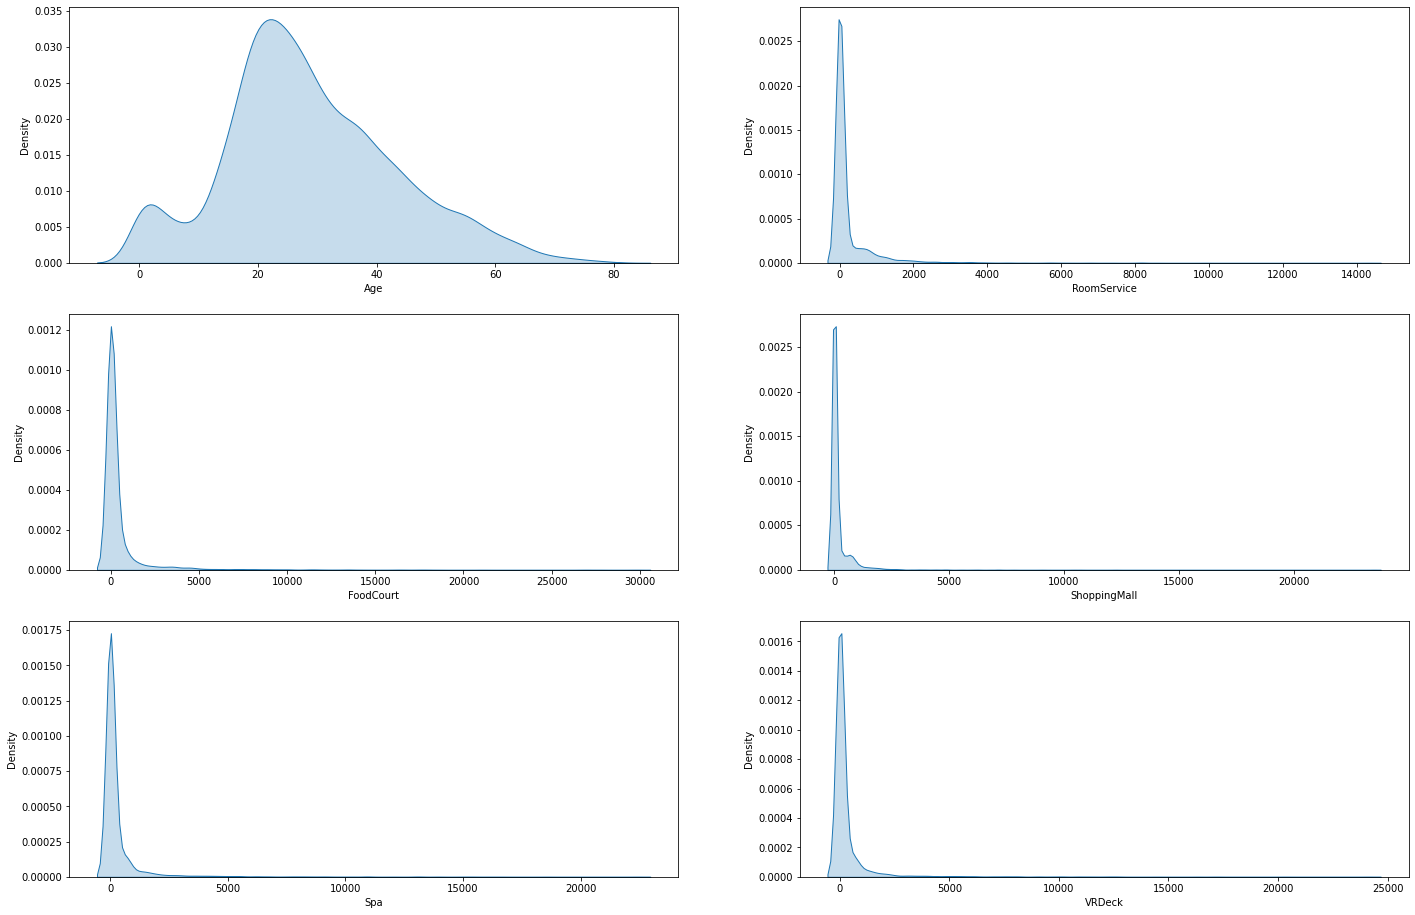

In [ ]:
fig, axs = plt.subplots(3, len(continuous_features)//3, figsize=(24,16))

sns.kdeplot(train_set[continuous_features[0]], shade=True, ax=axs[0][0])
sns.kdeplot(train_set[continuous_features[1]], shade=True, ax=axs[0][1])

sns.kdeplot(train_set[continuous_features[2]], shade=True, ax=axs[1][0])
sns.kdeplot(train_set[continuous_features[3]], shade=True, ax=axs[1][1])

sns.kdeplot(train_set[continuous_features[4]], shade=True, ax=axs[2][0])
sns.kdeplot(train_set[continuous_features[5]], shade=True, ax=axs[2][1])

plt.show()

**Bad Density**

- Well, we can see that the train_set is not well normalized, normalizing those features with 'bad' density is a good way to give our model more information. We can normalize those features with log. It depends on the model, but for neural nets and linear models it is a very good try. For tree based models rarely we can see a improvement, but always worth a try.
- Those Densities show as well that those 'spent' features has a lot of zero or close to zero values

**Features With 0 values**

- We can also see that all features has 0 or close to 0 values and what we can do with that??
- We can aggregate the features that has value greater than 0 and form a new feature with the function `gt` and sum()
- This can be extremally helpful to tree models, because those models don't have a neural way to aggregate information across many features at once

**Spent type**

- We can aggregate this spent features in only one feature "Total_Spent", giving to the model more information about the relationship between those features
- Tree based models can learn almost any relationship, but is good to show explicitly to the model the relationship between features
- Not only that, but linear models can benify a lot from this combination/formula too

We must deal with the missing values before see the relationship between those features and the target. 

But remember to split the dataset into training set and validation set before doing the imputation, if not we maybe are going to have a data leakage as the validation set maybe will affect each other

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_set.drop("Transported", axis=1), train_set.Transported, test_size=0.2, shuffle=True, stratify=train_set.Transported, random_state=0)

In [ ]:
na_numerical = train_set[numerical_features].isnull().sum()[train_set[numerical_features].isnull().sum() > 0].index.tolist()
train_set[numerical_features].isnull().sum()[train_set[numerical_features].isnull().sum() > 0]

Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy="mean")
X_train_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_train[numerical_features]))
X_val_imputed = pd.DataFrame(numerical_imputer.transform(X_val[numerical_features]))

## Giving back the columns names and the same index as X_train
X_train_imputed.columns = numerical_features
X_train_imputed.index = X_train.index

## Giving back the columns names and the same index as X_val
X_val_imputed.columns = numerical_features
X_val_imputed.index = X_val.index

X_train[numerical_features] = X_train_imputed
X_val[numerical_features] = X_val_imputed

In [ ]:
X_train[numerical_features].isnull().sum()[X_train[numerical_features].isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
X_val[numerical_features].isnull().sum()[X_val.isnull().sum() > 0]

Series([], dtype: int64)

Now let's see the relationship between those features and the target??

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X=X_train[continuous_features], y=Y_train, discrete_features=X_train[continuous_features].dtypes == "int64", random_state=0)
mi = pd.Series(mi, name="Mi Scores",index=continuous_features)
mi = mi.sort_values(ascending=False)
mi

Spa             0.077056
RoomService     0.072622
VRDeck          0.064131
FoodCourt       0.045565
ShoppingMall    0.043444
Age             0.009707
Name: Mi Scores, dtype: float64

From the mutual information scores we can infer those features alone don't have a significant relationship with the target, it is True??

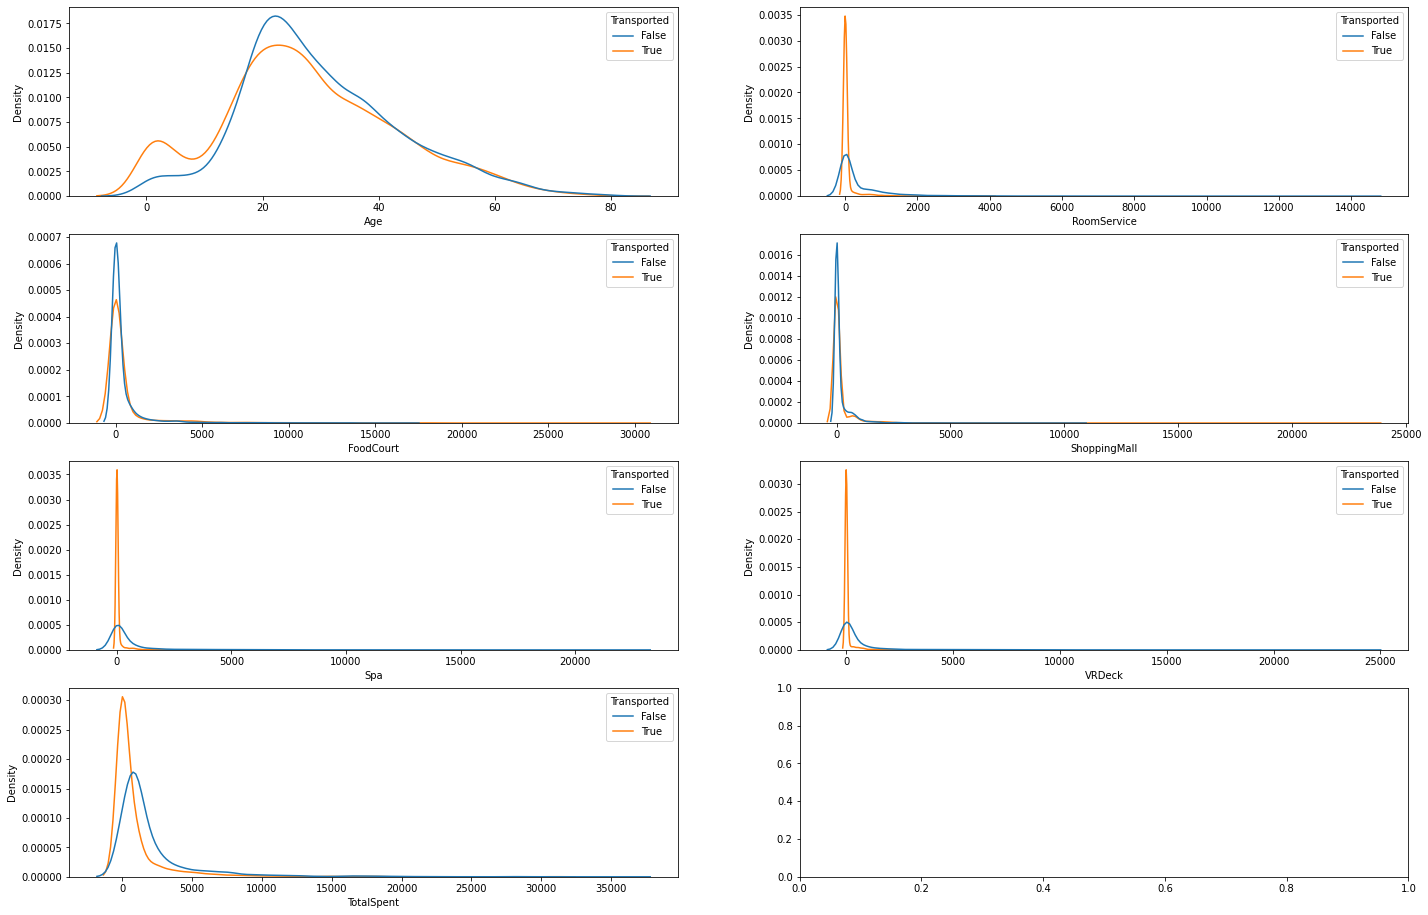

In [ ]:
fig, axs = plt.subplots(4, len(continuous_features)//3, figsize=(24,16))

sns.kdeplot(data=train_set, x=continuous_features[0], hue="Transported", ax=axs[0][0])
sns.kdeplot(data=train_set, x=continuous_features[1], hue="Transported", ax=axs[0][1])

sns.kdeplot(data=train_set, x=continuous_features[2], hue="Transported", ax=axs[1][0])
sns.kdeplot(data=train_set, x=continuous_features[3], hue="Transported", ax=axs[1][1])

sns.kdeplot(data=train_set, x=continuous_features[4], hue="Transported", ax=axs[2][0])
sns.kdeplot(data=train_set, x=continuous_features[5], hue="Transported", ax=axs[2][1])

## To see the TotalSpent
test_set = train_set.copy()
test_set["TotalSpent"] = train_set.RoomService + train_set.FoodCourt + train_set.ShoppingMall + train_set.Spa + train_set.VRDeck
sns.kdeplot(data=test_set, x="TotalSpent", hue="Transported", ax=axs[3][0])

plt.show()

- `Age`
  - We can see from the plot, that we can't see a great relationship between the age and the target alone, if we add the genre of the passanger...mayber turn on another thing
- `RoomService`
  - We can see a great relationship with the target when the feature has 0 value
- `FoodCourt`
  - We can see a great relationship with the target when the feature has 0 value
- `ShoppingMall`
  - We can't see a great relationship with the target
- `Spa`
  - We can't see a great relationship with the target
- `VRDeck`
  - We can see a great relationship with the target when the feature has 0 value

### Categorical and Boolean Features

In [ ]:
categorical_features = [feature for feature in train_set.columns if train_set[feature].dtype == "object"]
boolean_features = [feature for feature in train_set.columns if train_set[feature].dtype == "bool"]

In [ ]:
categorical_features

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [ ]:
boolean_features

['Transported']

**Let's see the features with high cardinality??**

Usually features with high cardinality don't give to our models much information, but maybe we can create new features with them that give to our model a relevant information

<br>

Let's begin??

In [ ]:
high_cardinality_columns = [feature for feature in train_set.drop("Transported", axis=1).columns if train_set[feature].nunique() > 10 and train_set[feature].dtype == "object"]
high_cardinality_columns

['PassengerId', 'Cabin', 'Name']

From the dataset dictionary we can see that the features PassengerId and Cabin are useful to create another features

**PassengerId**

In [ ]:
train_set.PassengerId.head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

In [ ]:
train_set.PassengerId.isnull().sum()

0

`PassengerId` - Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

We can break this feature in two another features
  - Group
    - The group's id
  - N_members
    - The number of persons into the group

We can create a feature that specify if the passenger is alone or not, for explicitly give the model this information

**Cabin**

In [ ]:
train_set.Cabin.head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

In [ ]:
train_set.Cabin.isnull().sum()

199

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

We can break this feature in another three features:
  - Deck
  - Num
  - Side

**Name**

In [ ]:
train_set.Name.head()

0      Maham Ofracculy
1         Juanna Vines
2        Altark Susent
3         Solam Susent
4    Willy Santantines
Name: Name, dtype: object

In [ ]:
train_set.Name.isnull().sum()

200

We can create another family indicating if the passenger group's is family or not

If the passenger isn't alone and the last name of the group's persons is the same, then we have a family

Other than that, I can't see a good way to retrieve insights from the Name

<br>

**And the features with low cardinality?**

In general, those features tend to give our model relevant informations

In [ ]:
low_cardinality_columns = set([column for column in X_train.columns if X_train[column].dtype == "object"]) - set(high_cardinality_columns)
low_cardinality_columns

{'CryoSleep', 'Destination', 'HomePlanet', 'VIP'}

#### Cryosleep

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


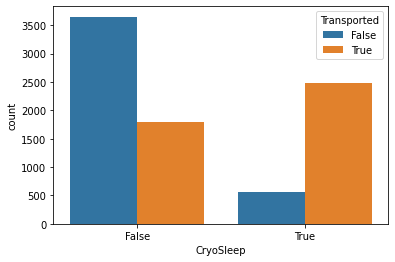

In [ ]:
sns.countplot(train_set.CryoSleep, hue=train_set.Transported)
plt.show()

We can see that the `CryoSleep` feature decrease the uncertainty about the target, because the majority of observations with `CryoSleep` set as True was transported

<br>

Let's try to relate the Cryosleep with another features

In [ ]:
train_set.columns.tolist()

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

Maybe we can see if the CryoSleep feature has any relationship with HomePlanet, Destination, Age, VIP and TotalSpent

**HomePlanet**

We can see from the charts below that the HomePlanet and CryoSleep together decrease the uncertainty about the target

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


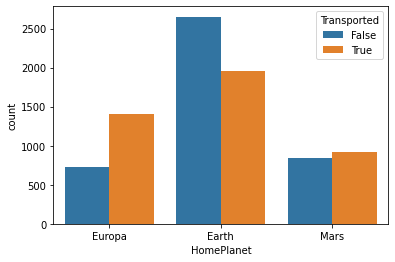

In [ ]:
sns.countplot(train_set.HomePlanet, hue=train_set.Transported)
plt.show()

In [ ]:
homeplanet_values = train_set.HomePlanet.unique().tolist()
homeplanet_values

['Europa', 'Earth', 'Mars', nan]

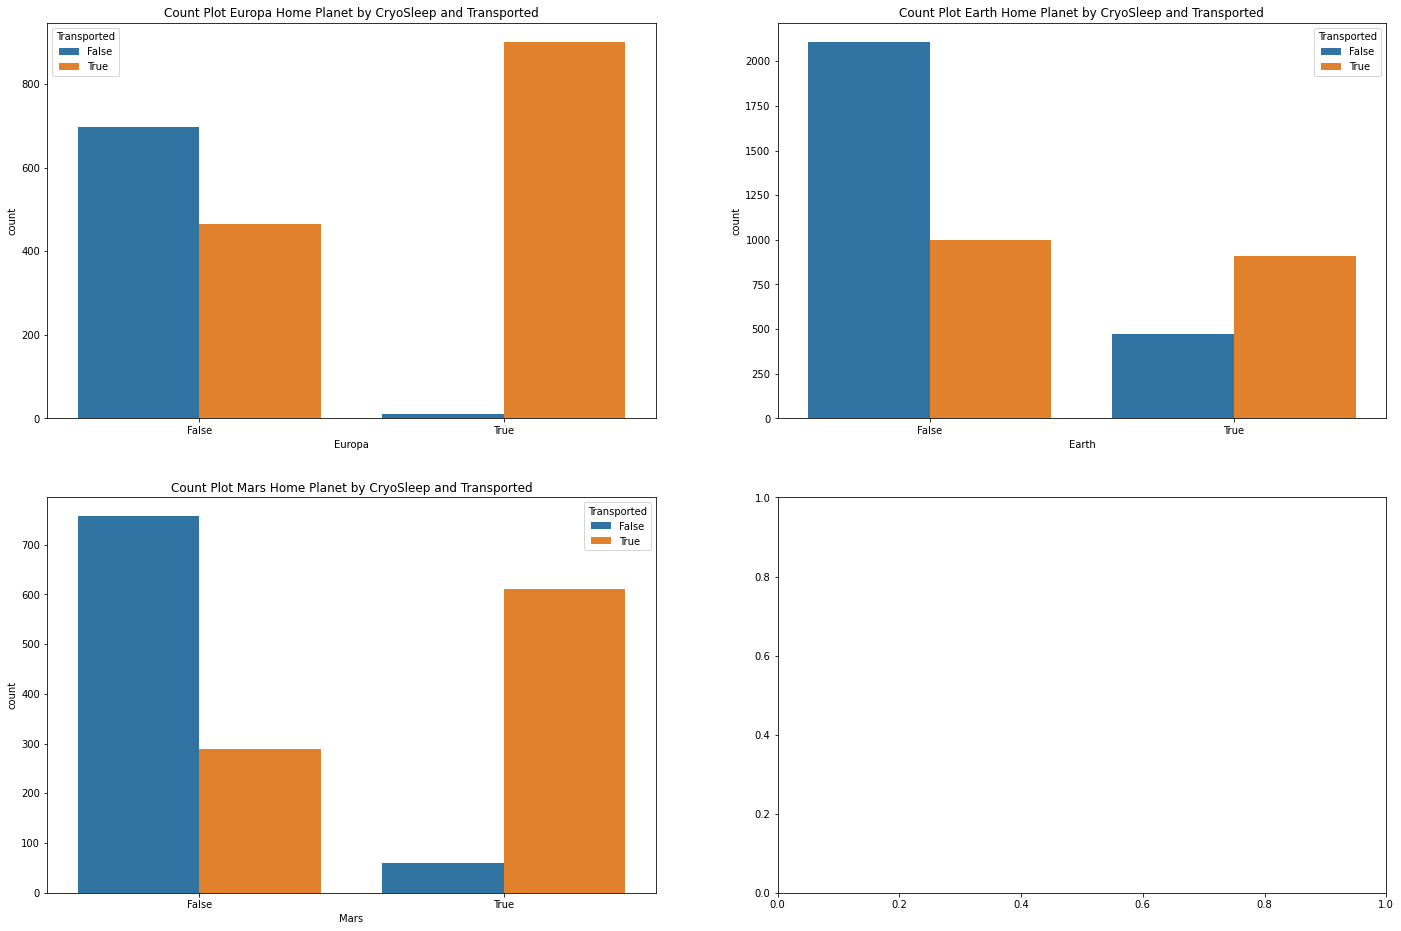

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

ax1 = sns.countplot(x=train_set[train_set["HomePlanet"] == homeplanet_values[0]].CryoSleep, hue=train_set[train_set["HomePlanet"] == homeplanet_values[0]].Transported, ax=axs[0][0])
ax1.set_xlabel(homeplanet_values[0])
ax1.set_title(f"Count Plot {homeplanet_values[0]} Home Planet by CryoSleep and Transported")

ax2 = sns.countplot(x=train_set[train_set["HomePlanet"] == homeplanet_values[1]].CryoSleep, hue=train_set[train_set["HomePlanet"] == homeplanet_values[1]].Transported, ax=axs[0][1])
ax2.set_xlabel(homeplanet_values[1])
ax2.set_title(f"Count Plot {homeplanet_values[1]} Home Planet by CryoSleep and Transported")

ax3 = sns.countplot(x=train_set[train_set["HomePlanet"] == homeplanet_values[2]].CryoSleep, hue=train_set[train_set["HomePlanet"] == homeplanet_values[2]].Transported, ax=axs[1][0])
ax3.set_xlabel(homeplanet_values[2])
ax3.set_title(f"Count Plot {homeplanet_values[2]} Home Planet by CryoSleep and Transported")
# sns.countplot(x=train_set[train_set["HomePlanet"] == homeplanet_values[3]].CryoSleep, hue=train_set[train_set["HomePlanet"] == homeplanet_values[3]].Transported, ax=axs[1][1])

plt.show()

**Destination**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


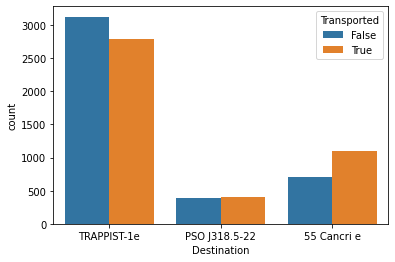

In [ ]:
sns.countplot(train_set.Destination, hue=train_set.Transported)

In [ ]:
destination_values = train_set.Destination.unique().tolist()
destination_values

['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan]

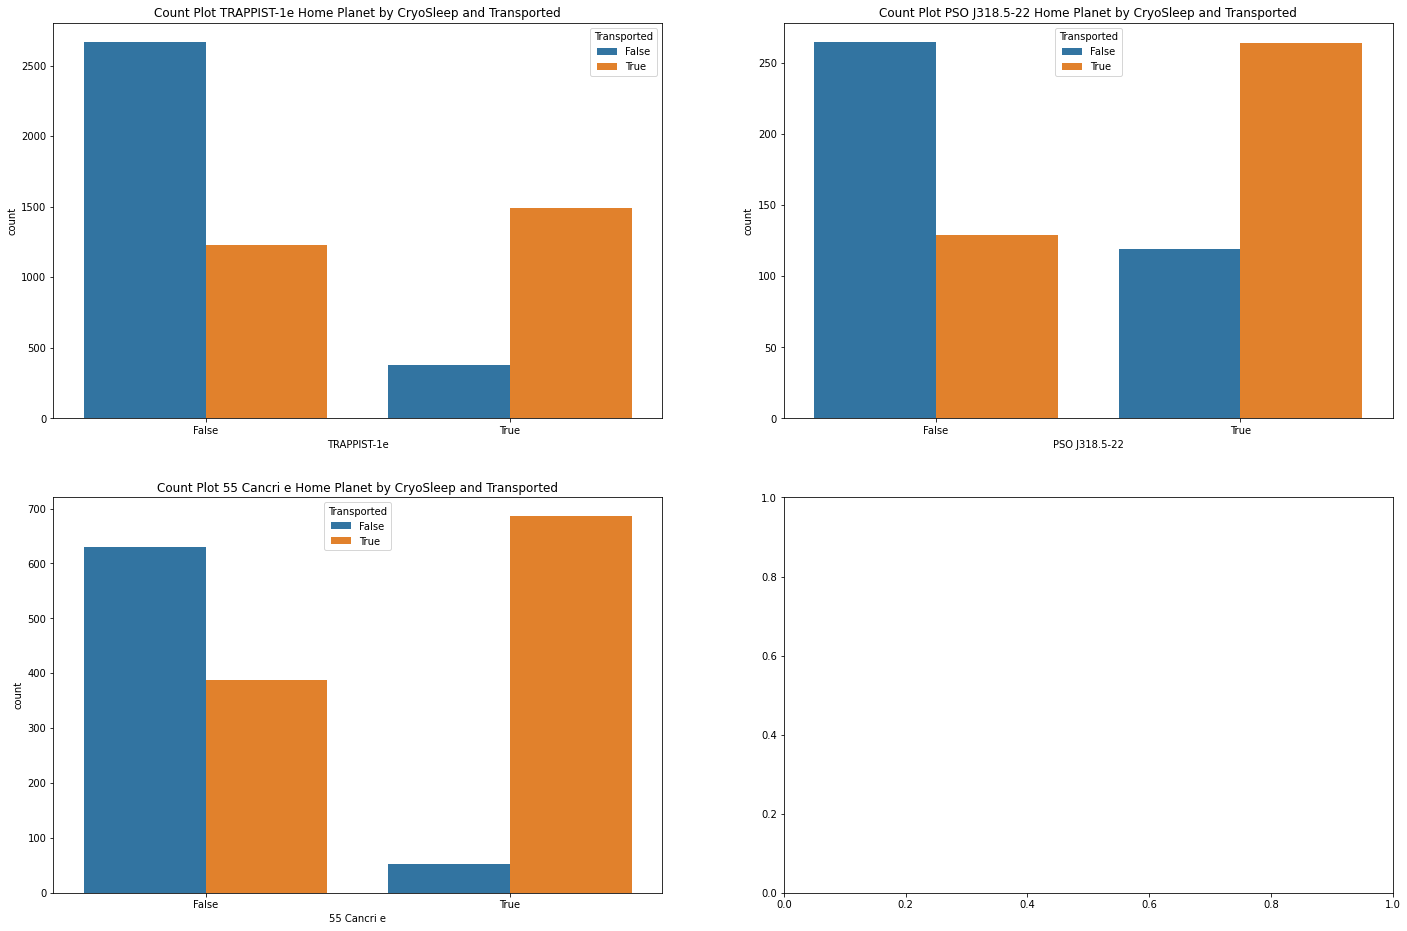

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

ax1 = sns.countplot(x=train_set[train_set["Destination"] == destination_values[0]].CryoSleep, hue=train_set[train_set["Destination"] == destination_values[0]].Transported, ax=axs[0][0])
ax1.set_xlabel(destination_values[0])
ax1.set_title(f"Count Plot {destination_values[0]} Home Planet by CryoSleep and Transported")

ax2 = sns.countplot(x=train_set[train_set["Destination"] == destination_values[1]].CryoSleep, hue=train_set[train_set["Destination"] == destination_values[1]].Transported, ax=axs[0][1])
ax2.set_xlabel(destination_values[1])
ax2.set_title(f"Count Plot {destination_values[1]} Home Planet by CryoSleep and Transported")

ax3 = sns.countplot(x=train_set[train_set["Destination"] == destination_values[2]].CryoSleep, hue=train_set[train_set["Destination"] == destination_values[2]].Transported, ax=axs[1][0])
ax3.set_xlabel(destination_values[2])
ax3.set_title(f"Count Plot {destination_values[2]} Home Planet by CryoSleep and Transported")
# sns.countplot(x=train_set[train_set["HomePlanet"] == homeplanet_values[3]].CryoSleep, hue=train_set[train_set["HomePlanet"] == homeplanet_values[3]].Transported, ax=axs[1][1])

plt.show()

**Age**

As we can see from the charts below, the Age feature doesn't have a relationship with CryoSleep

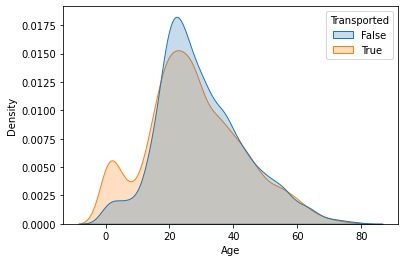

In [ ]:
sns.kdeplot(x=train_set.Age, hue=train_set.Transported, shade=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 80.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


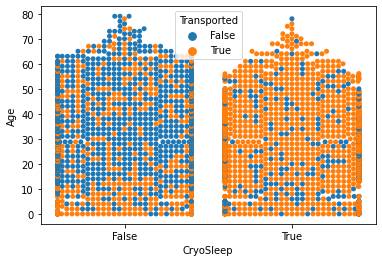

In [ ]:
aux_set = X_train.copy()[["CryoSleep", "Age"]]
aux_set = pd.concat([aux_set, Y_train.copy()], axis=1)
aux_set = aux_set.dropna(axis="rows")

sns.swarmplot(x=aux_set.CryoSleep, y=aux_set.Age, hue=aux_set.Transported)
plt.show()

We can infer some things from the chart above:
  - The Age feature doesn't have a good relationship with the CryoSleep feature, in general
  - Majority of the Transported passengers that aren't in CryoSleep is between 0 and 10 years

We can use these assumptions to create new features too

**VIP**

As we can see from the charts below, all VIP passengers in CryoSleep was transported.

We can make use of that making another feature that shows if the passenger is VIP and is in CryoSleep

In [ ]:
aux_set = X_train.copy()[["CryoSleep", "VIP"]]
aux_set = pd.concat([aux_set, Y_train.copy()], axis=1)
aux_set = aux_set.dropna(axis="rows")

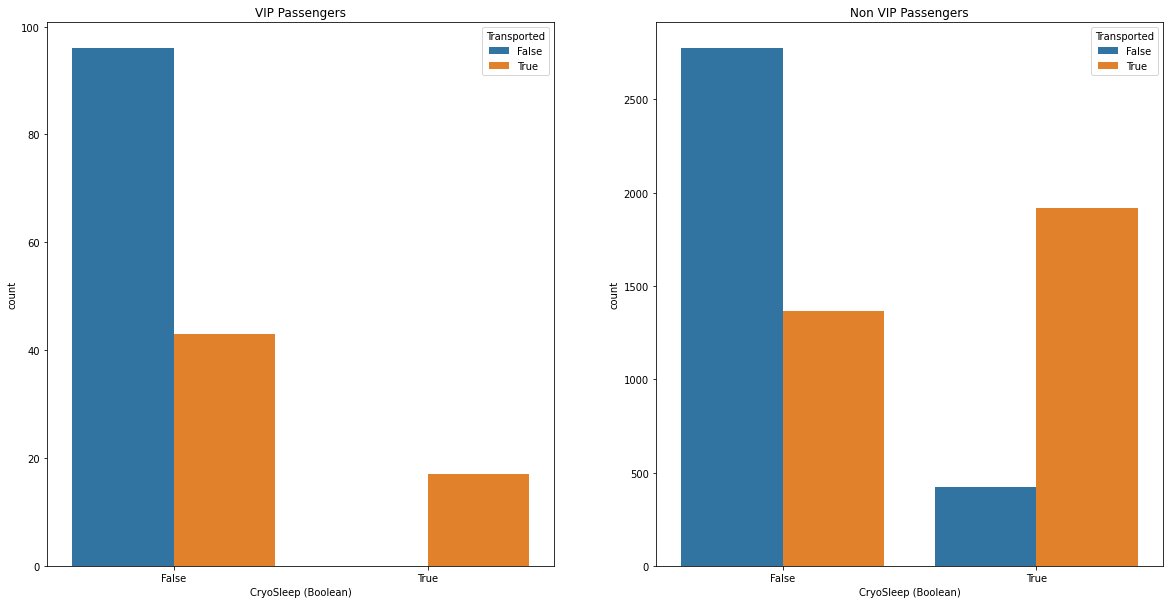

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

smplt1 = sns.countplot(x=aux_set[aux_set["VIP"] == True].CryoSleep, hue=aux_set.Transported, ax=axs[0])
smplt1.set_xlabel("CryoSleep (Boolean)")
smplt1.set_title("VIP Passengers")

smplt2 = sns.countplot(x=aux_set[aux_set["VIP"] == False].CryoSleep, hue=aux_set.Transported, ax=axs[1])
smplt2.set_xlabel("CryoSleep (Boolean)")
smplt2.set_title("Non VIP Passengers")

plt.show()

**Spent Features**

In [ ]:
spent_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpent"]
aux_set = X_train.copy()[["CryoSleep", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]]
aux_set = pd.concat([aux_set, Y_train.copy()], axis=1)
aux_set = aux_set.dropna(axis="rows")
aux_set["TotalSpent"] = train_set.RoomService + train_set.FoodCourt + train_set.ShoppingMall + train_set.Spa + train_set.VRDeck

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 82.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


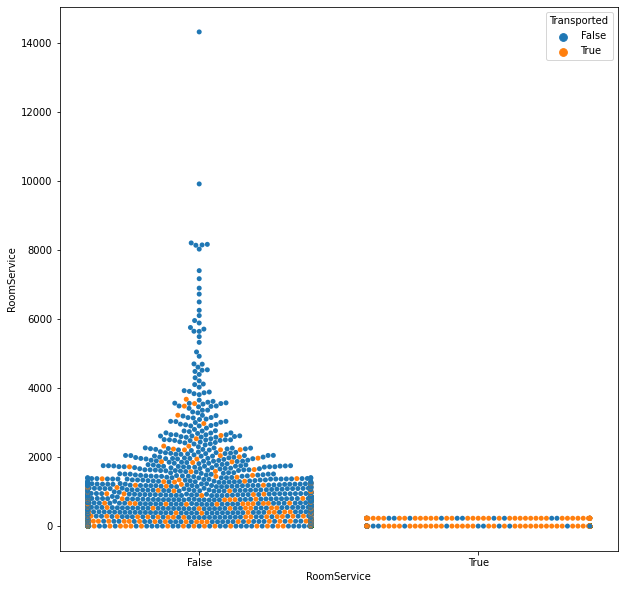

In [ ]:
plt.figure(figsize=(10, 10))

swarm1 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[0]], hue=aux_set.Transported)
plt.xlabel(spent_features[0])

plt.show()

We can see from the swarmplot above that the RoomService feature doesn't have a good relationship with the target and the CryoSleep Feature

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 82.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


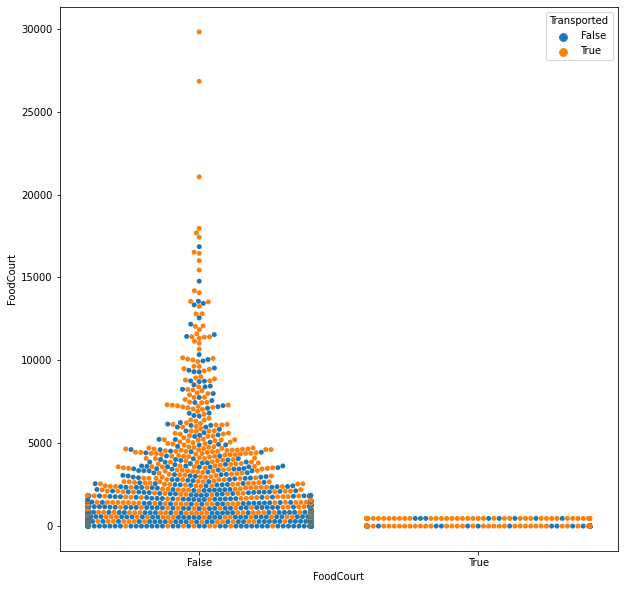

In [ ]:
plt.figure(figsize=(10, 10))

swarm2 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[1]], hue=aux_set.Transported)
plt.xlabel(spent_features[1])

plt.show()

We can see from the swarmplot above that the FoodCourt feature have a good relationship with the Target and the  CryoSleep feature

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 98.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


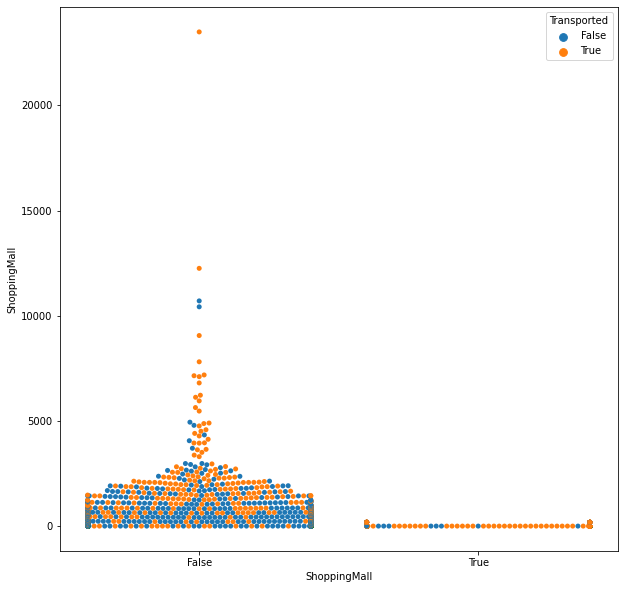

In [ ]:
plt.figure(figsize=(10, 10))

swarm3 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[2]], hue=aux_set.Transported)
plt.xlabel(spent_features[2])

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


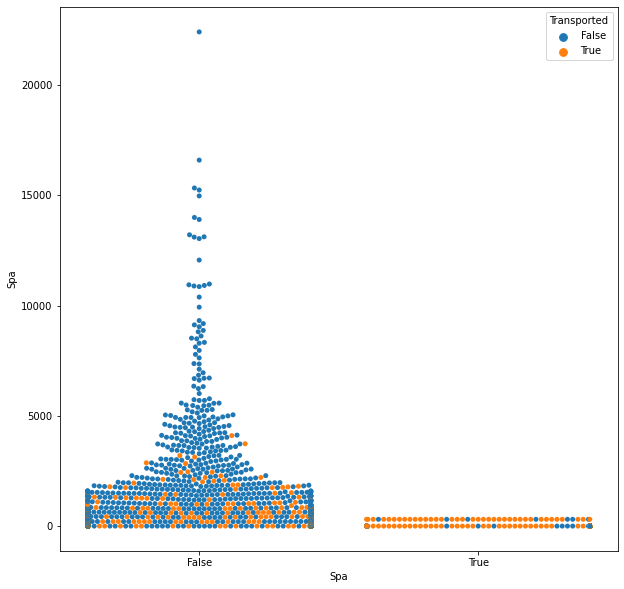

In [ ]:
plt.figure(figsize=(10, 10))

swarm4 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[3]], hue=aux_set.Transported)
plt.xlabel(spent_features[3])

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


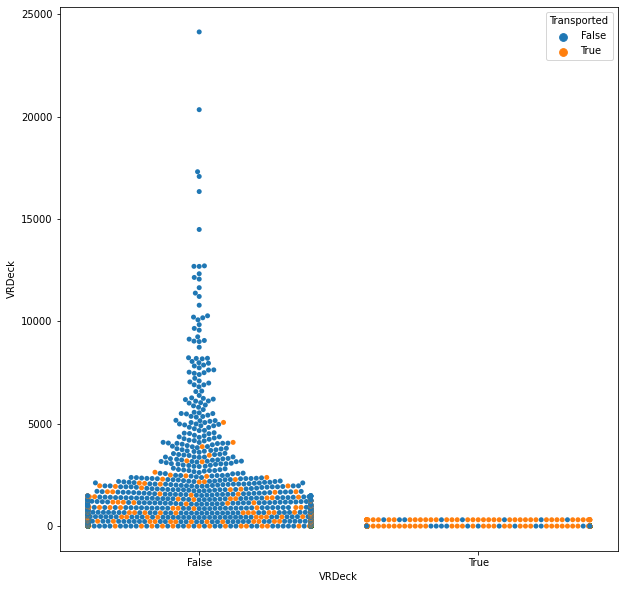

In [ ]:
plt.figure(figsize=(10, 10))

swarm5 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[4]], hue=aux_set.Transported)
plt.xlabel(spent_features[4])

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 64.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


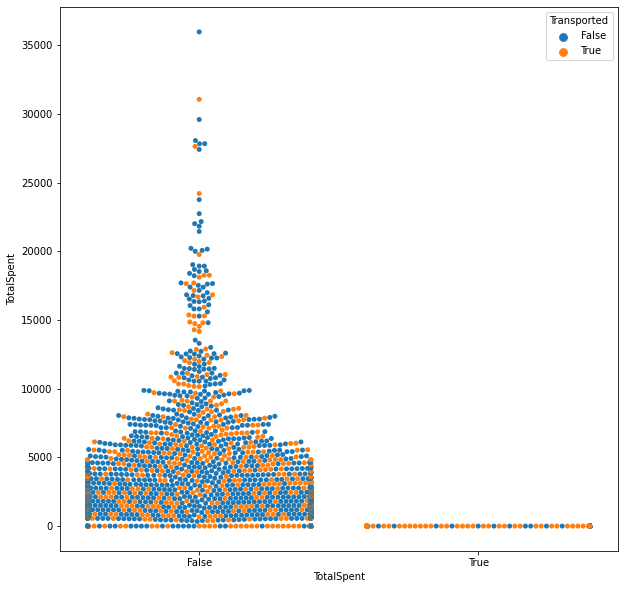

In [ ]:
plt.figure(figsize=(10, 10))

swarm6 = sns.swarmplot(x=aux_set.CryoSleep, y=aux_set[spent_features[5]], hue=aux_set.Transported)
plt.xlabel(spent_features[5])

plt.show()

We have to see the relationship between those spent features, because maybe this can show us the major locations that the passengers was transported and we can use that to use feature engineering and create another feature

We can infer that a lot of transported people has a TotalSpent of zero, because majority of transported people was in CryoSleep, then they spent nothing. Maybe this can explained more about the Cabin feature, because maybe the Cabin location has something to say about the taregt

Maybe those spent features that have a good relationship with the target and CryoSleep feature have a good relationship with each other. And this we can explore to do a feature engineering and create another feature

**There is still a need to study more the attributes of destination, home planet, vip and cabin. But for now that's all. Remove the ourliers too. I'll update the notebook through the week**

Tenho que ver a relação do CryoSleep com a Cabine também